In [ ]:
# !pip install cuda-python

In [ ]:
!pip install cupy-cuda111

In [ ]:
!pip install mpi4py

In [ ]:
import cupy as cp
import numpy as np
from cupyx.scipy.signal import convolve2d as cp_convolve2d
from mpi4py import MPI
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.transform import resize
from scipy.signal import convolve2d

## Task 10. Saxpy

By using <u><i><strong>CuPy</strong></i></u>, implement SAXPY function. The function is described in the picture.

![saxpy](saxpy.jpg)

CuPy is numpy accelerated with GPU (uses GPU and works faster). CuPy makes computations on GPU but in case we need to use the result on CPU or to print result somehow then it transfers (copies) data to CPU (user may not notice) and it may take time.

In [ ]:
SAXPY=cp.ElementwiseKernel(
    'int64 a,float32 x,float32 y','float32 z',
        '''z=a*x+y;''',
    'my_kernel')

In [ ]:
x=cp.arange(3, dtype='f')
y=cp.arange(3, dtype='f')
a=cp.random.randint(0, 4)
print("Input x = \n", x)
print("\nInput y = \n", y)

result = SAXPY(a,x,y)

print("\nresult of the kernel =\n", result)

Input x = 
 [0. 1. 2.]

Input y = 
 [0. 1. 2.]

result of the kernel =
 [0. 1. 2.]


In [ ]:
a*x + y

array([0., 1., 2.])

In [ ]:
cpu_times = []
gpu_times = []
for n in 2**np.arange(26):
    x=cp.arange(n, dtype='f')
    y=cp.arange(n, dtype='f')
    a=cp.random.randint(0, 4)
    time = %timeit -q -o -n 1000 -r 1 a*x + y
    cpu_times.append(time.best)
    time = %timeit -q -o -n 1000 -r 1 SAXPY(a,x,y)
    gpu_times.append(time.best)

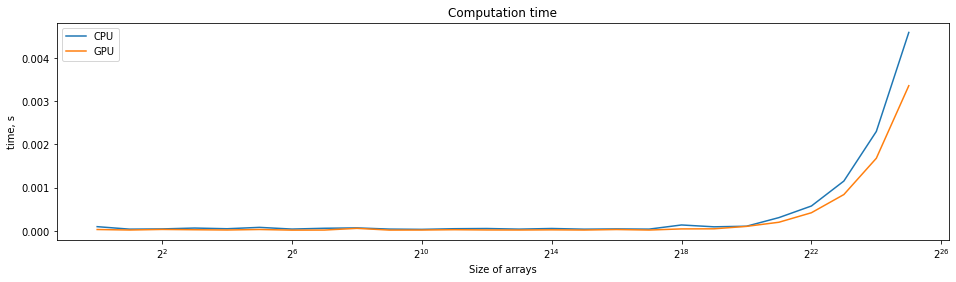

In [ ]:
plt.figure(figsize=(16,4))
plt.title('Computation time')
plt.plot(2**np.arange(26), cpu_times, label='CPU')
plt.plot(2**np.arange(26), gpu_times, label='GPU')
plt.xlabel('Size of arrays')
plt.ylabel('time, s')
plt.xscale('log', basex=2)
plt.legend()

## Task 11. CuPy-based Bifurcation map

By using <u><i><strong>CuPy</strong></i></u>, reimplement bifurcation map (Task 1).

### CPU

In [ ]:
n = 1000
last = 100
x0 = 0.2
r = np.linspace(0, 4, 10000)
R = (np.ones((last, len(r))) * r).T.reshape(-1)
xs = np.ones(len(r)) * x0
X = np.empty((n, len(r)))
X[0] = r * xs * (1 - xs)

for i in np.arange(1, 1000):
    x = r * X[i-1] * (1 - X[i-1])
    X[i] = x

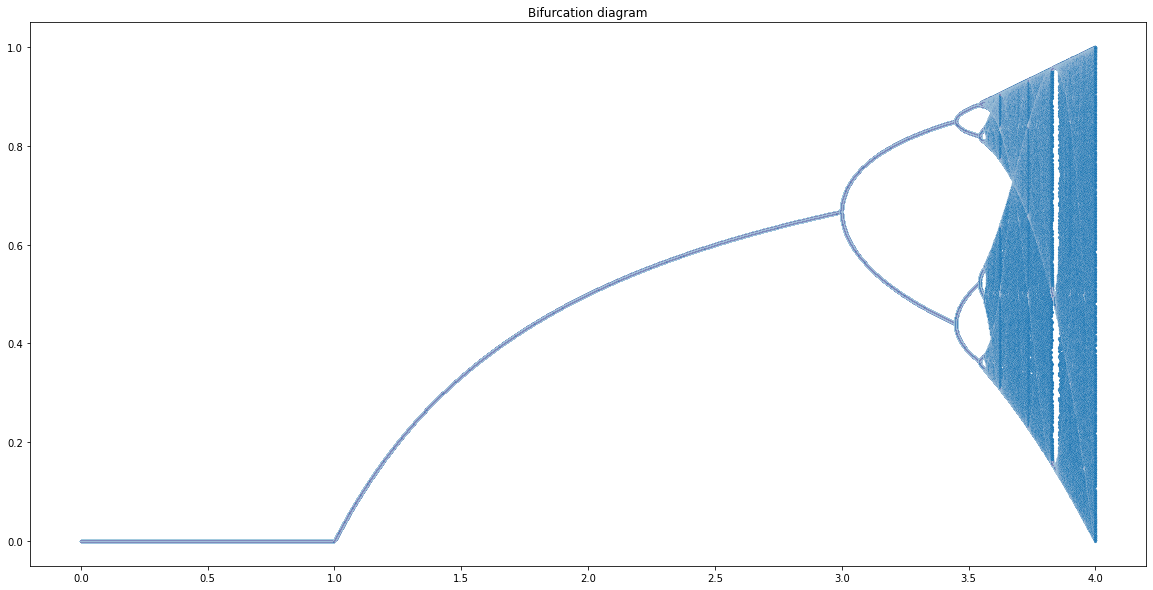

In [ ]:
plt.figure(figsize=(20, 10))
plt.title('Bifurcation diagram')
sns.scatterplot(x=R, y=X[-100:].T.flatten(), s=10, linewidth=0.07)

In [ ]:
def bifurcation(n, last=100, x0=0.2):
    last = 100
    x0 = 0.2
    r = np.linspace(0, 4, 10000)
    R = (np.ones((last, len(r))) * r).T.reshape(-1)
    xs = np.ones(len(r)) * x0
    X = np.empty((n, len(r)))
    X[0] = r * xs * (1 - xs)

    for i in np.arange(1, n):
        x = r * X[i-1] * (1 - X[i-1])
        X[i] = x

    return R, X

In [ ]:
times = []
for n in 10**np.arange(5):
    time = %timeit -q -o -n 1 -r 1 bifurcation(n=n)
    times.append(time.best)

### MPI

In [ ]:
mpi_times = []

In [ ]:
%%writefile test.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

n = 1
last = 100
x0 = 0.2

start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

r = np.linspace(rank*4/size, (rank+1)*4/size, 10000//size)
if rank==0:
  R = (np.ones((last, len(r))) * r).T.reshape(-1)
xs = np.ones(len(r)) * x0
X = np.empty((n, len(r)))
X[0] = r * xs * (1 - xs)

for i in np.arange(1, n):
    x = r * X[i-1] * (1 - X[i-1])
    X[i] = x

X = np.array(comm.gather(X, root=0))

end = MPI.Wtime()

if rank==0: 
    print(end-start)

Overwriting test.py


In [ ]:
!mpirun --allow-run-as-root -n 2 python test.py

0.007896900000105234


In [ ]:
mpi_times.append(0.007896900000105234)

In [ ]:
%%writefile test.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

n = 10
last = 100
x0 = 0.2

start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

r = np.linspace(rank*4/size, (rank+1)*4/size, 10000//size)
if rank==0:
  R = (np.ones((last, len(r))) * r).T.reshape(-1)
xs = np.ones(len(r)) * x0
X = np.empty((n, len(r)))
X[0] = r * xs * (1 - xs)

for i in np.arange(1, n):
    x = r * X[i-1] * (1 - X[i-1])
    X[i] = x

X = np.array(comm.gather(X, root=0))

end = MPI.Wtime()

if rank==0: 
    print(end-start)

Overwriting test.py


In [ ]:
!mpirun --allow-run-as-root -n 2 python test.py

0.03320180900004743


In [ ]:
mpi_times.append(0.03320180900004743)

In [ ]:
%%writefile test.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

n = 100
last = 100
x0 = 0.2

start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

r = np.linspace(rank*4/size, (rank+1)*4/size, 10000//size)
if rank==0:
  R = (np.ones((last, len(r))) * r).T.reshape(-1)
xs = np.ones(len(r)) * x0
X = np.empty((n, len(r)))
X[0] = r * xs * (1 - xs)

for i in np.arange(1, n):
    x = r * X[i-1] * (1 - X[i-1])
    X[i] = x

X = np.array(comm.gather(X, root=0))

end = MPI.Wtime()

if rank==0: 
    print(end-start)

Overwriting test.py


In [ ]:
!mpirun --allow-run-as-root -n 2 python test.py

0.030470298999944134


In [ ]:
mpi_times.append(0.030470298999944134)

In [ ]:
%%writefile test.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

n = 1000
last = 100
x0 = 0.2

start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

r = np.linspace(rank*4/size, (rank+1)*4/size, 10000//size)
if rank==0:
  R = (np.ones((last, len(r))) * r).T.reshape(-1)
xs = np.ones(len(r)) * x0
X = np.empty((n, len(r)))
X[0] = r * xs * (1 - xs)

for i in np.arange(1, n):
    x = r * X[i-1] * (1 - X[i-1])
    X[i] = x

X = np.array(comm.gather(X, root=0))

end = MPI.Wtime()

if rank==0: 
    print(end-start)

Overwriting test.py


In [ ]:
!mpirun --allow-run-as-root -n 2 python test.py

0.3915280009998696


In [ ]:
mpi_times.append(0.3915280009998696)

In [ ]:
%%writefile test.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

n = 10000
last = 100
x0 = 0.2

start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

r = np.linspace(rank*4/size, (rank+1)*4/size, 10000//size)
if rank==0:
  R = (np.ones((last, len(r))) * r).T.reshape(-1)
xs = np.ones(len(r)) * x0
X = np.empty((n, len(r)))
X[0] = r * xs * (1 - xs)

for i in np.arange(1, n):
    x = r * X[i-1] * (1 - X[i-1])
    X[i] = x

X = np.array(comm.gather(X, root=0))

end = MPI.Wtime()

if rank==0: 
    print(end-start)

Overwriting test.py


In [ ]:
!mpirun --allow-run-as-root -n 2 python test.py

4.288899250999975


In [ ]:
mpi_times.append(4.288899250999975)

### CuPy

In [ ]:
next_x=cp.ElementwiseKernel(
    'float64 r, float64 x','float64 z',
        '''z=r*x*(1-x);''',
    'next_x')

In [ ]:
r = cp.linspace(0, 4, 10000)
xs = cp.ones(len(r)) * x0
next_x(r, xs)

array([0.00000000e+00, 6.40064006e-05, 1.28012801e-04, ...,
       6.39871987e-01, 6.39935994e-01, 6.40000000e-01])

In [ ]:
n = 1000
last = 100
x0 = 0.2
r = cp.linspace(0, 4, 10000)
R = (cp.ones((last, len(r))) * r).T.reshape(-1)
xs = cp.ones(len(r)) * x0
X = cp.empty((n, len(r)))
X[0] = next_x(r, xs)

for i in cp.arange(1, 1000):
    x = next_x(r, X[i-1])
    X[i] = x

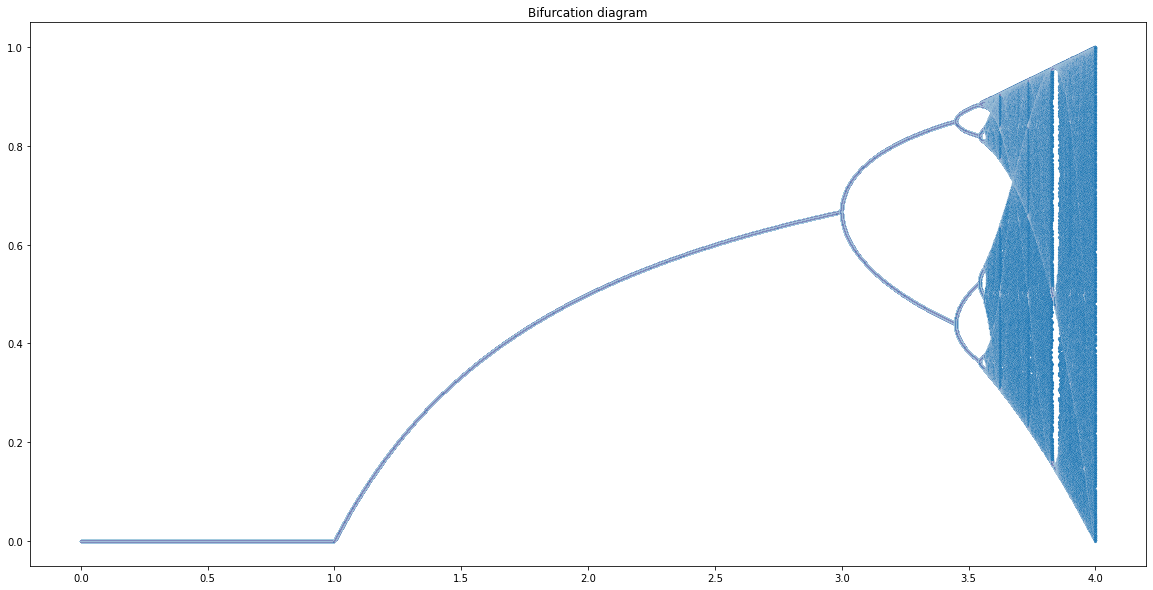

In [ ]:
plt.figure(figsize=(20, 10))
plt.title('Bifurcation diagram')
sns.scatterplot(x=R.get(), y=X[-100:].T.flatten().get(), s=10, linewidth=0.07)

In [ ]:
# !pip install snakeviz

In [ ]:
%load_ext snakeviz

In [ ]:
%%snakeviz
n = 1000
last = 100
x0 = 0.2
r = cp.linspace(0, 4, 10000)
R = (cp.ones((last, len(r))) * r).T.reshape(-1)
xs = cp.ones(len(r)) * x0
X = cp.empty((n, len(r)))
X[0] = next_x(r, xs)

for i in cp.arange(1, 1000):
    x = next_x(r, X[i-1])
    X[i] = x

 
*** Profile stats marshalled to file '/tmp/tmpcl82uq7l'. 
Embedding SnakeViz in this document...


In [ ]:
def bifurcation(n, last=100, x0=0.2):
    last = 100
    x0 = 0.2
    r = cp.linspace(0, 4, 10000)
    R = (cp.ones((last, len(r))) * r).T.reshape(-1)
    xs = cp.ones(len(r)) * x0
    X = cp.empty((n, len(r)))
    X[0] = next_x(r, xs)

    for i in cp.arange(1, n):
        x = next_x(r, X[i-1])
        X[i] = x

    return R, X

In [ ]:
gpu_times = []
for n in 10**cp.arange(5):
    time = %timeit -q -o -n 1 -r 1 bifurcation(n=int(n))
    gpu_times.append(time.best)

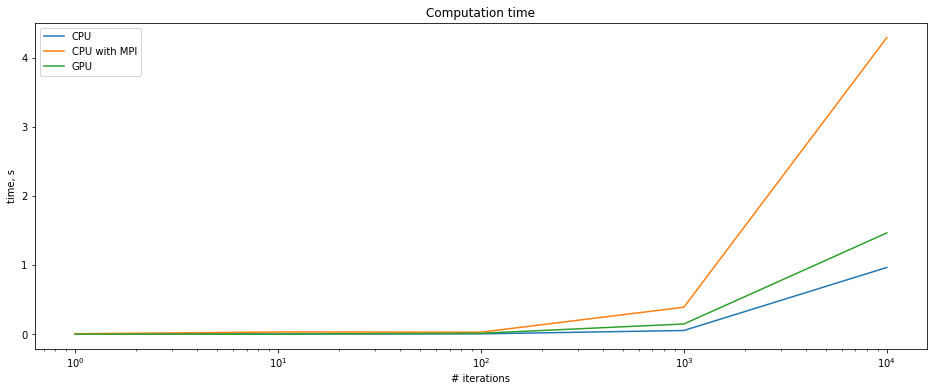

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Computation time')
plt.plot(10**np.arange(5), times, label='CPU')
plt.plot(10**np.arange(5), mpi_times, label='CPU with MPI')
plt.plot(10**np.arange(5), gpu_times, label='GPU')
plt.xlabel('# iterations')
plt.xscale('log')
plt.ylabel('time, s')
plt.legend()

I'm not surprised with MPI because my original code computes in parallel for each r simultaneously

## Task 12. Histogram


<u>By using <i><strong>CuPy</strong></i>:</u>
* Implement the suggested function:
$$
 f(x) = (z^2(x) + z^3(x) - 200 \,\, z^4(x) )\,\,\sin(\,\,100000\,\,(x + 0.5)\,\,),
 \\
 \text{where    }\:\:\: z(x) = \sin(3\,\,x)-0.5
$$
* Plot function on the $x$ interval $[0,\,\, 1]$. Number of points = 10000000.
* Get minimal and maximal values of function on the interval $[0,\,\, 1]$: $f_{min}$ and $f_{max}$.
* Divide $y=f(x), \: (x \in [0,\,\, 1]) \:$ interval $[f_{min}, f_{max}]$ into $10$ $y=f(x)$ subintervals of length $\delta$ equal to $0.1 \,\, (f_{max}-f_{min})$: $[f_{min},\,\, f_{min} + \delta],\,\, [f_{min}+ \delta,\,\, f_{min} + 2 \,\, \delta],\,\, \dots,\,\, [f_{max}- \delta,\,\, f_{max}]$.
* Compute number of $y=f(x), \: (x \in [0,\,\, 1]) \:$ values in each subinterval. Use $\operatorname{cp.sum(\dots)}$
* Plot histogram. <strong>[Hint: how to represent the histogram](https://cdn.datamentor.io/wp-content/uploads/2017/11/r-histogram.png)</strong>

<strong >Hint about function $f(x)$ appearance:</strong>
    ![Hint](Hint.png)

In [ ]:
def f(x):
    z = cp.sin(3*x) - 0.5
    f = (z**2 + z**3 - 200*z**4) * cp.sin(100000*(x+0.5))
    return f

In [ ]:
x = cp.linspace(0, 1, 10000000)
f = f(x)

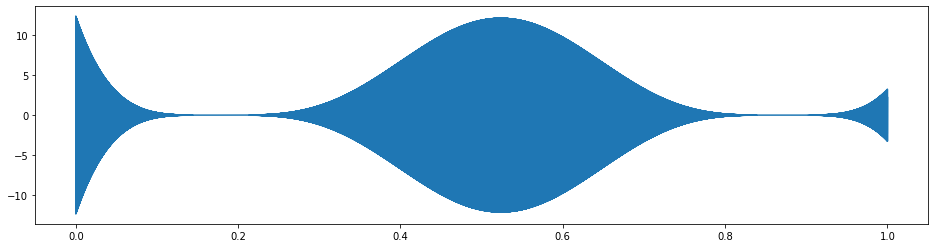

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(x.get(), f.get())

In [ ]:
fmin = cp.min(f)
fmax = cp.max(f)

In [ ]:
h = 0.1 * (fmax - fmin)
bins = cp.ones(10) * fmin + h * cp.arange(10)
hist = cp.array([])
for i in range(10):
    hist = cp.append(hist, (fmin + h * i <= f)*(f < fmin + h * (i + 1)))

hist = hist.reshape(10,-1)

In [ ]:
%timeit -n 100 -r 10 cp.sum(hist, axis=1)

The slowest run took 389.54 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 10: 42 µs per loop


In [ ]:
%timeit -n 100 -r 10 np.sum(hist, axis=1)

The slowest run took 229.29 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 10: 71.4 µs per loop


In [ ]:
hist = cp.sum(hist.reshape(10,-1), axis=1)

Text(0, 0.5, 'Frequency')

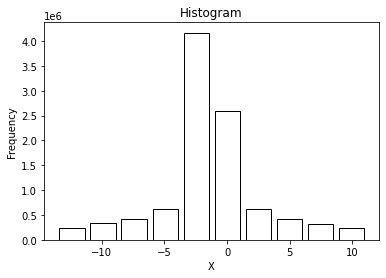

In [ ]:
plt.bar(x = bins.get(), height=hist.get(), width=2, color='white', edgecolor='k')
plt.title('Histogram')
plt.xlabel('X')
plt.ylabel('Frequency')

## Task 13. Image blur


<u>By using <i><strong>CuPy</strong></i>:</u>
* Implement the gpu version of the image blur algorithm. What you need to do is calculate convolution some image and some blur filter on every pixel. You should compute convolutions in parallel for every pixel using gpu cores.
* Take any 100x100 image and 

<strong >Example of a blurred image:</strong>
    ![Blur](blur.jpg)

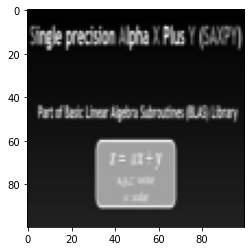

In [ ]:
# Before
img = resize(cv2.imread('saxpy.jpg', 0), (100,100))
plt.imshow(img, cmap='gray');

In [ ]:
k = 11
kernel = cp.ones((k,k)) / k**2

In [ ]:
blur_img = cp_convolve2d(cp.asarray(img), kernel)

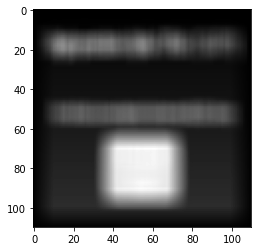

In [ ]:
# After
plt.imshow(blur_img.get(), cmap='gray')

In [ ]:
# Cupy
%timeit cp_convolve2d(cp.asarray(img), kernel)

247 µs ± 46.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
k = 11
kernel = np.ones((k,k)) / k**2

In [ ]:
# Scipy (I use it instead of numpy)
%timeit convolve2d(img, kernel)

2.41 ms ± 15 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
